In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import scipy.signal
import pandas as pd
from tqdm.notebook import tqdm
import gc
import pickle
from transforms import adaptive_resize
import seaborn as sns
from pathlib import Path


In [23]:
PATH = 'input/g2net-detecting-continuous-gravitational-waves/test'
PATH_EX = 'input/g2net-detecting-continuous-gravitational-waves/external'
OUT = 'input/g2net-detecting-continuous-gravitational-waves/denoise_H.pickle'

files = [os.path.join(PATH_EX,f) for f in sorted(os.listdir(PATH_EX))]
T = 1800
SR = 16384 # !!! change if work with 4096 SR data
SZ = 360
TH = 1.5
SOURCE = 'H1_SFTs_amplitudes'


df = pd.read_csv('input/test_stationery.csv').head(100)
df = df.loc[~df.stationery]
df.head()

,id,stationery,freq
14,004f1b282,False,391.430278
17,006e25113,False,479.295278
23,008ec5560,False,317.477500
24,00948246a,False,227.008611
38,0112d6cc3,False,335.537500


In [24]:
from transforms import adaptive_resize

def load_test_spec(gid, use_complex=False, return_time=False):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
    if use_complex:
        if return_time:
            return sig_h1, sig_l1, time_h1, time_l1
        else:
            return sig_h1, sig_l1
    else:
        spec_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        spec_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        if return_time:
            return spec_h1, spec_l1, time_h1, time_l1
        else:
            return spec_h1, spec_l1


def resize_image(img, img_size):
    return adaptive_resize(img[:, :, None], img_size, np.mean)[:, :, 0]

In [25]:
def read_hdf5(fname):
    with h5py.File(fname, 'r') as f:
        strain = f['strain']['Strain'][:]
        ts = f['strain']['Strain'].attrs['Xspacing']

        metaKeys = f['meta'].keys()
        meta = f['meta']
        gpsStart = meta['GPSstart'][()]
        duration = meta['Duration'][()]
        has_nan = strain[np.isnan(strain)].size > 0
    return {'strain':strain, 'ts':ts, 
            'gpsStart':gpsStart, 'duration':duration, 'has_nan':has_nan}


def extract_data_from_hdf5(path):
    data = {}
    # with h5py.File(path, "r") as f:
    #     ID_key = list(f.keys())[0]
    #     # Retrieve the frequency data
    #     data['freq'] = np.array(f[ID_key]['frequency_Hz'])
    #     # Retrieve the Livingston decector data
    #     data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
    #     data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
    #     # Retrieve the Hanford decector data
    #     data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
    #     data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    with open(path, 'rb') as fp:
        f = pickle.load(fp)
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data


class Model_FFT(nn.Module):
    def __init__(self, N=SR*T, sr=SR):
        super().__init__()
        window = scipy.signal.windows.tukey(N, 0.001)
        self.window = nn.Parameter(torch.from_numpy(window),requires_grad=False)
        self.range = [89500,901500] #50-500 Hz
        self.freq = (np.fft.rfftfreq(N)*sr)[self.range[0]:self.range[1]]
        self.sr, self.N = sr, N
        
    def forward(self, x):
        with torch.no_grad():
            ys,shifts = [],[]
            for i in range(0,x.shape[-1] - self.N, self.sr):
                xi = x[i:i+self.N]
                if torch.isnan(xi).any(-1): continue
                y = torch.fft.rfft(xi*self.window)[self.range[0]:self.range[1]] / self.sr
                y = (y*1e22).abs().float().cpu()
                ys.append(y)
                shifts.append(i//self.sr)
        return torch.stack(ys,0), torch.LongTensor(shifts)

In [4]:
# fft_model = Model_FFT()
# freq = fft_model.freq

# denoised_data = {}
# for index, row in tqdm(df.iterrows(), total=len(df)):
#     idx = row['id']
#     data_src = extract_data_from_hdf5(os.path.join(PATH, idx+'.pickle'))
#     src = torch.zeros(data_src[SOURCE].shape)
#     denoised_data[idx] = src

In [5]:
# for fname in files:
#     print(fname)
#     data = torch.from_numpy(read_hdf5(fname)['strain'])
#     # stfts,shifts = fft_model(data.float().cuda())
#     stfts,shifts = fft_model(data.float())
#     del data
    
#     for index, row in tqdm(df.iterrows(), total=len(df)):
#         idx = row['id']
#         # data_src = extract_data_from_hdf5(os.path.join(PATH, idx+'.hdf5'))
#         data_src = extract_data_from_hdf5(os.path.join(PATH, idx+'.pickle'))
#         freq_start = (np.abs(freq - data_src['freq'][0])).argmin()

#         tgt = stfts[:,freq_start:freq_start+SZ]
#         src = torch.from_numpy(np.abs(data_src[SOURCE]*1e22)).permute(1,0)
#         # dists = torch.cdist(src.cuda(),tgt.cuda()).cpu()
#         dists = torch.cdist(src,tgt)

#         if dists.min() < TH:
#             values,indices = dists.min(-1)
#             #print(indices[values < TH], torch.where(values < TH)) ##
#             denoised_data[idx][:,values < TH] = (src[values < TH] - tgt[indices[values < TH]]).T
#     gc.collect()
#     break

In [6]:
# with open(OUT, 'wb') as f:
#     pickle.dump(denoised_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
def resize_image(img, img_size):
    return adaptive_resize(img[:, :, None], img_size, np.mean)[:, :, 0]

In [7]:
with open(OUT, 'rb') as f:
    denoised_data = pickle.load(f)

In [8]:
match_summary = []
for key in tqdm(denoised_data.keys()):
    v = np.abs(denoised_data[key].numpy())
    max_time = v.max(0)
    if max_time.max() > 0: # match
        time_slice = v[:, max_time.argmax()]
        signal_stat = time_slice.max() / time_slice.std()
        match_summary.append({'id': key, 'signal_stat': signal_stat})
        # print(f'{key}: stat = {signal_stat:.3f}')

        # plt.plot(v[:, max_time.argmax()])
        # # plt.savefig(f'input/plot/denoise/{key}.png', facecolor='white')
        # plt.show()
        # plt.close()
match_summary = pd.DataFrame(match_summary)

  0%|          | 0/1497 [00:00<?, ?it/s]

In [11]:
match_summary

,id,signal_stat
0,004f1b282,3.829022
1,038047700,10.803078
2,06254d84b,17.835577
3,09d7ea37a,4.554331
4,0b4c34044,4.036593
...,...,...
112,f30a0a053,4.016056
113,f63ab5d46,7.676837
114,f76c95ffe,4.184474
115,f96d37d25,4.726449


<AxesSubplot:xlabel='signal_stat', ylabel='Count'>

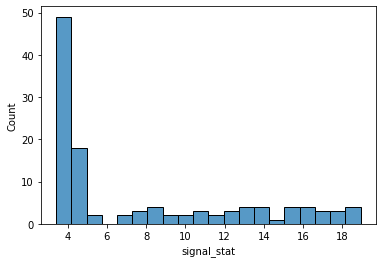

In [9]:
sns.histplot(match_summary['signal_stat'], bins=20)

  0%|          | 0/1 [00:00<?, ?it/s]

d1466f6b3 (4): stat = 17.506


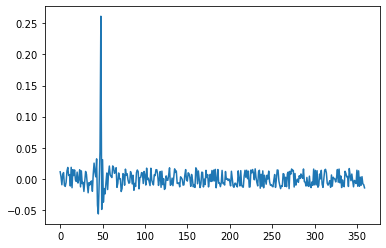

In [21]:
# for key in tqdm(match_summary.query('10 <signal_stat')['id']):
for key in tqdm(match_summary.query('id == "d1466f6b3"')['id']):
    v = denoised_data[key].numpy()
    max_time = np.abs(v).max(0)
    time_slice = np.abs(v[:, max_time.argmax()])
    signal_stat = time_slice.max() / time_slice.std()
    print(f'{key} ({max_time.argmax()}): stat = {signal_stat:.3f}')
    plt.plot(v[:, max_time.argmax()])
    plt.show()
    plt.close()

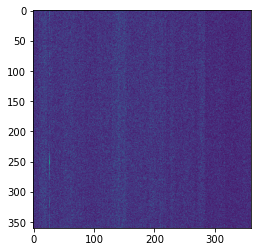

In [18]:
plt.imshow(resize_image(load_test_spec('e2fa690a6')[0], 360))

In [11]:
match_summary['target'] = (match_summary['signal_stat'] > 5).astype(int)
leak_target = pd.read_csv('input/denoised_target.csv')
best_sub = pd.read_csv('input/predictions/submission785.csv')

In [12]:
match_summary.query('target == 1').merge(best_sub, on='id', how='inner')

,id,signal_stat,target_x,target_y
0,038047700,11.103790,1,0.663636
1,06254d84b,17.861933,1,0.686884
2,13dad6fd2,16.049669,1,0.916301
3,163f2d88e,17.917051,1,0.953592
4,16f87f070,8.564960,1,0.742708
5,1ac04e8fb,17.627592,1,0.911611
6,20c78eaa9,12.451344,1,0.013592
7,2e492b264,9.787285,1,0.541455
8,2f594acf6,12.757933,1,0.956176
9,2f5dfb161,13.778603,1,0.969981


In [13]:
match_summary.to_csv('input/external_leak_target.csv', index=False)